In [2]:
# Cell 1: Import and Setup
import sys
sys.path.append('..')  # Add parent directory to path

import torch
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Import your custom modules
from src.data.dataset import ChestXrayDataset, create_data_splits, calculate_class_weights
from src.data.dataloader import create_rtx3060_dataloaders

# Use your paths from previous EDA
BASE_PATH = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")  # Update this!

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

D:\Projects\CLARITY\Model\CLARITY.env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
D:\Projects\CLARITY\Model\CLARITY.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 3060
VRAM: 12.9 GB


In [3]:
# Cell 2: Load Data (use your variables from EDA)
# You should have these from your EDA notebook:
# - df: DataFrame with metadata
# - image_mapping: Dict mapping image names to paths

# If you don't have them, reload:
if 'df' not in locals() or 'image_mapping' not in locals():
    print("Loading data from EDA results...")
    
    # Load metadata
    data_entry_path = BASE_PATH / "Data_Entry_2017.csv"
    if data_entry_path.exists():
        df = pd.read_csv(data_entry_path)
        print(f"Loaded metadata: {len(df):,} entries")
    else:
        print("❌ Need to run EDA first to get df and image_mapping")
    
    # Recreate image mapping
    image_mapping = {}
    for main_folder in sorted(BASE_PATH.iterdir()):
        if main_folder.is_dir() and main_folder.name.startswith('images_'):
            images_subfolder = main_folder / 'images'
            if images_subfolder.exists():
                for img_file in images_subfolder.glob("*.png"):
                    image_name = img_file.name
                    if image_name not in image_mapping:
                        image_mapping[image_name] = img_file
    
    print(f"Created image mapping: {len(image_mapping):,} images")

print(f"Dataset ready: {len(df):,} metadata entries, {len(image_mapping):,} images")

Loading data from EDA results...
Loaded metadata: 112,120 entries
Created image mapping: 112,120 images
Dataset ready: 112,120 metadata entries, 112,120 images


In [4]:
# Cell 3: Create Data Splits
train_df, val_df, test_df = create_data_splits(df, 
                                               test_size=0.15,  # 15% for test
                                               val_size=0.10,   # 10% for val
                                               random_seed=42)

print(f"\nSplit verification:")
print(f"Total samples: {len(df):,}")
print(f"Train + Val + Test: {len(train_df) + len(val_df) + len(test_df):,}")
print(f"Match: {len(df) == len(train_df) + len(val_df) + len(test_df)}")

Patient-level data splits:
  Train: 83,847 images from 23,105 patients (74.8%)
  Val:   11,550 images from 3,080 patients (10.3%)
  Test:  16,723 images from 4,620 patients (14.9%)
✅ No patient overlap verified - clean splits!

Split verification:
Total samples: 112,120
Train + Val + Test: 112,120
Match: True


In [5]:
# Cell 4: Create Datasets
print("Creating datasets...")

# Create datasets with different image sizes for testing
train_dataset = ChestXrayDataset(
    df=train_df,
    image_mapping=image_mapping,
    image_size=512,  # Start with 512 for RTX 3060
    is_training=True,
    augmentation_prob=0.8
)

val_dataset = ChestXrayDataset(
    df=val_df,
    image_mapping=image_mapping,
    image_size=512,
    is_training=False  # No augmentation for validation
)

test_dataset = ChestXrayDataset(
    df=test_df,
    image_mapping=image_mapping,
    image_size=512,
    is_training=False
)

print(f"\nDatasets created successfully!")
print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples") 
print(f"Test:  {len(test_dataset)} samples")

Creating datasets...
Dataset created with 83847 samples
Training mode: True
Image size: 512x512

Label matrix created: (83847, 15)
Positive samples per class:
  No Finding...............  45146
  Atelectasis..............   8720
  Cardiomegaly.............   2019
  Effusion.................  10071
  Infiltration.............  14772
  Mass.....................   4477
  Nodule...................   4691
  Pneumonia................   1062
  Pneumothorax.............   3981
  Consolidation............   3458
  Edema....................   1738
  Emphysema................   1794
  Fibrosis.................   1236
  Pleural_Thickening.......   2562
  Hernia...................    171
Transforms created for training
Dataset created with 11550 samples
Training mode: False
Image size: 512x512

Label matrix created: (11550, 15)
Positive samples per class:
  No Finding...............   6197
  Atelectasis..............   1148
  Cardiomegaly.............    331
  Effusion.................   1311
  Inf

D:\Projects\CLARITY\Model\CLARITY.env\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
D:\Projects\CLARITY\Model\Project\notebooks\..\src\data\dataset.py:108: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),


In [6]:
# Cell 5: Calculate Class Weights
print("Calculating class weights for imbalanced dataset...")

class_weights = calculate_class_weights(train_dataset.labels, method='inverse_freq')
print(f"\nClass weights tensor shape: {class_weights.shape}")
print(f"Weight range: {class_weights.min():.3f} to {class_weights.max():.3f}")

Calculating class weights for imbalanced dataset...

Class weights (inverse_freq):
--------------------------------------------------
No Finding...............    0.031 (pos:  45146)
Atelectasis..............    0.158 (pos:   8720)
Cardiomegaly.............    0.684 (pos:   2019)
Effusion.................    0.137 (pos:  10071)
Infiltration.............    0.093 (pos:  14772)
Mass.....................    0.308 (pos:   4477)
Nodule...................    0.294 (pos:   4691)
Pneumonia................    1.299 (pos:   1062)
Pneumothorax.............    0.347 (pos:   3981)
Consolidation............    0.399 (pos:   3458)
Edema....................    0.794 (pos:   1738)
Emphysema................    0.769 (pos:   1794)
Fibrosis.................    1.116 (pos:   1236)
Pleural_Thickening.......    0.539 (pos:   2562)
Hernia...................    8.030 (pos:    171)

Class weights tensor shape: torch.Size([15])
Weight range: 0.031 to 8.030


In [7]:
# Cell 6: Create DataLoaders
print("Creating RTX 3060 optimized dataloaders...")

train_loader, val_loader, test_loader = create_rtx3060_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=8,  # Safe for RTX 3060 with 512px images
    num_workers=2,  # Optimal for most systems
    use_weighted_sampling=True
)

# Calculate memory usage estimate
batch_size = 8
image_size = 512
channels = 3
dtype_size = 4  # float32

memory_per_batch_gb = (batch_size * channels * image_size * image_size * dtype_size) / 1e9
print(f"\nMemory usage estimate:")
print(f"  Per batch: ~{memory_per_batch_gb:.2f} GB")
print(f"  With gradients: ~{memory_per_batch_gb * 2:.2f} GB")
print(f"  Total training: ~{memory_per_batch_gb * 3:.2f} GB (safe for RTX 3060)")

Creating RTX 3060 optimized dataloaders...
Creating RTX 3060 optimized dataloaders:
  Batch size: 8
  Num workers: 2
  Weighted sampling: True
  Weighted sampler created with 83847 samples
DataLoaders created:
  Train: 10480 batches
  Val:   1444 batches
  Test:  2091 batches

Memory usage estimate:
  Per batch: ~0.03 GB
  With gradients: ~0.05 GB
  Total training: ~0.08 GB (safe for RTX 3060)


In [8]:
# Cell 7: Test Data Loading
print("Testing data loading...")

# Test single batch
try:
    sample_batch = next(iter(train_loader))
    images, labels, metadata = sample_batch
    
    print(f"✅ Batch loaded successfully!")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Metadata keys: {list(metadata.keys())}")
    print(f"  Image tensor range: {images.min():.3f} to {images.max():.3f}")
    print(f"  Labels dtype: {labels.dtype}")
    print(f"  Device: {images.device}")
    
    # Check for GPU transfer
    if torch.cuda.is_available():
        images_gpu = images.cuda()
        print(f"  GPU transfer successful: {images_gpu.device}")
        
        # Clear GPU memory
        del images_gpu
        torch.cuda.empty_cache()

except Exception as e:
    print(f"❌ Error loading batch: {e}")

Testing data loading...
✅ Batch loaded successfully!
  Images shape: torch.Size([8, 3, 512, 512])
  Labels shape: torch.Size([8, 15])
  Metadata keys: ['image_name', 'patient_id', 'age', 'gender', 'view_position', 'findings']
  Image tensor range: -2.118 to 2.640
  Labels dtype: torch.float32
  Device: cpu
  GPU transfer successful: cuda:0


Visualizing training batch samples:


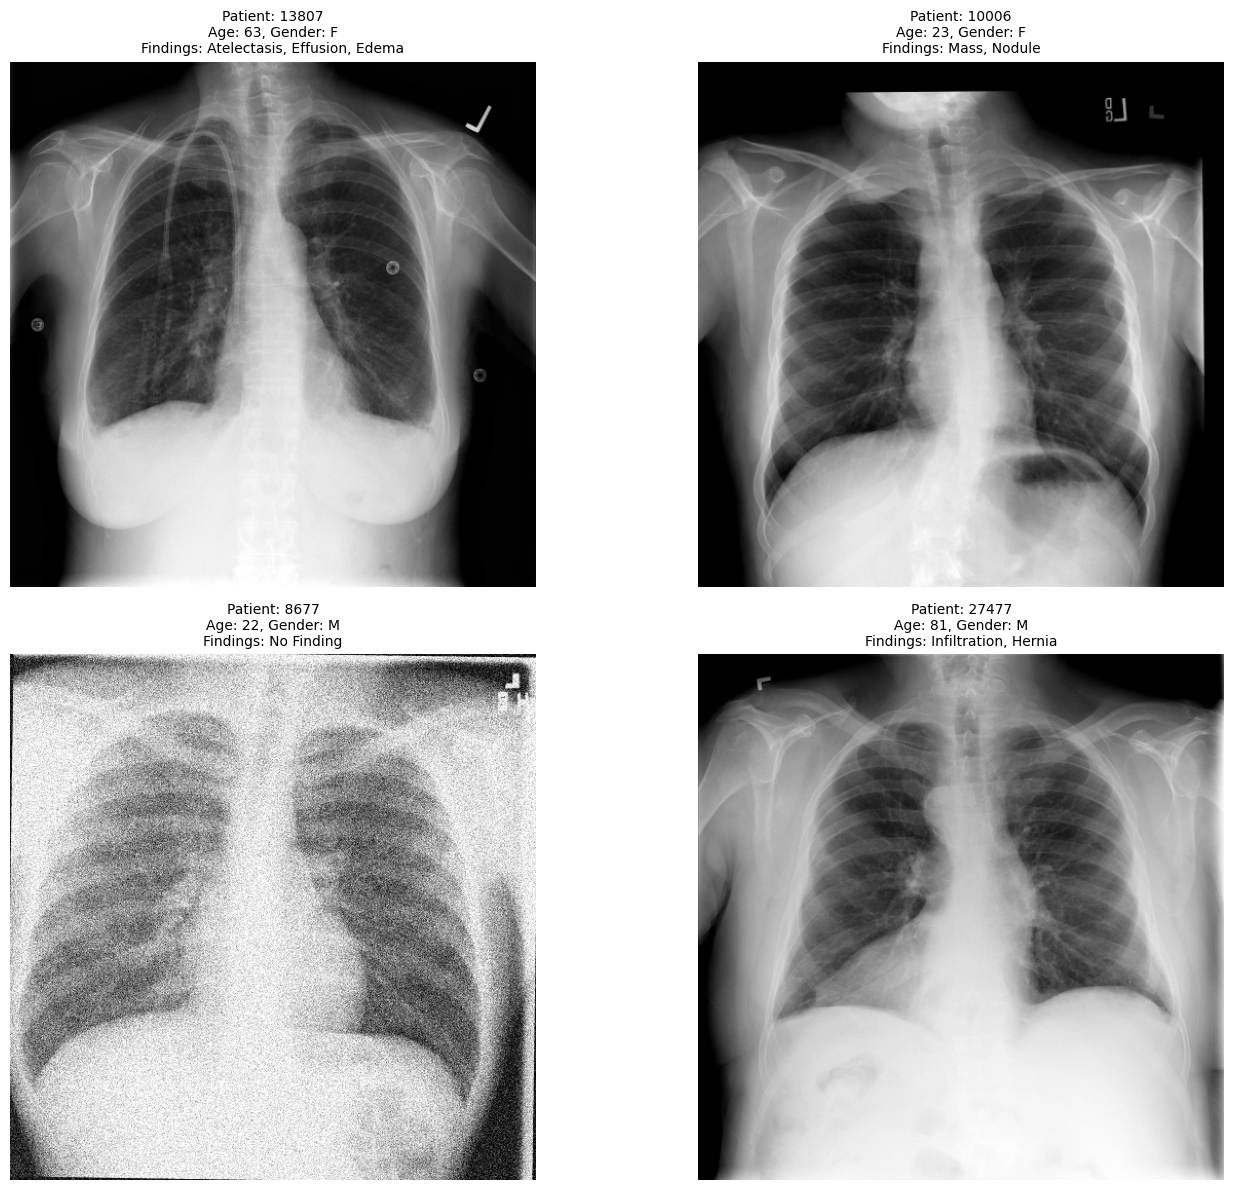

✅ Visualization completed successfully!


In [11]:
# Cell 8: Visualize Sample Batch - FIXED
def visualize_batch(dataloader, disease_classes, num_samples=4):
    """Visualize a sample batch with labels"""
    
    batch = next(iter(dataloader))
    images, labels, metadata = batch
    
    # Convert tensor back to numpy for visualization
    images_np = images.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        # Denormalize image for display
        img = images_np[i].transpose(1, 2, 0)
        # Reverse ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img * std + mean).clip(0, 1)
        
        # Convert to grayscale for better chest X-ray visualization
        img_gray = np.mean(img, axis=2)
        
        axes[i].imshow(img_gray, cmap='gray')
        
        # Get positive labels for this image - FIXED
        pos_indices = np.where(labels_np[i] > 0)[0]  # Extract the indices array
        pos_diseases = [disease_classes[idx] for idx in pos_indices]
        
        # Create title
        title = f"Patient: {metadata['patient_id'][i]}\n"
        title += f"Age: {metadata['age'][i]}, Gender: {metadata['gender'][i]}\n"
        title += f"Findings: {', '.join(pos_diseases) if pos_diseases else 'None'}"
        
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training batch
print("Visualizing training batch samples:")
try:
    visualize_batch(train_loader, train_dataset.disease_classes, num_samples=4)
    print("✅ Visualization completed successfully!")
except Exception as e:
    print(f"❌ Visualization error: {e}")
    
    # Debug information
    batch = next(iter(train_loader))
    images, labels, metadata = batch
    print(f"Debug info:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Sample label: {labels[0]}")
    print(f"  Positive indices: {np.where(labels[0] > 0)}")